# Detrend and Estimate Noise

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import scipy.optimize as op
import scipy.signal as sig
from   scipy import stats
from   scipy import fftpack
from   scipy import ndimage
from   scipy.interpolate import UnivariateSpline
import astropy
from   astropy.io import fits as pyfits

import csv
import sys
import os
import importlib as imp
import glob
from   timeit import default_timer as timer
import warnings
import progressbar
import argparse
import json
from   copy import deepcopy

import lightkurve as lk
import exoplanet as exo
import theano.tensor as T
import pymc3 as pm
import corner

from alderaan.constants import *
from alderaan.utils import *
from alderaan.Planet import *
from alderaan.LiteCurve import *
import alderaan.io as io
import alderaan.detrend as detrend
import alderaan.noise as noise
from alderaan.omc import omc_model
from alderaan.omc import choose_omc_model


# flush buffer to avoid mixed outputs from progressbar
sys.stdout.flush()

# turn off FutureWarnings
warnings.filterwarnings('ignore', category=FutureWarning)

# start program timer
global_start_time = timer()

# LCIT and SCIT in [1/days]
lcit = LCIT/60/24
scit = SCIT/3600/24

# Manually set I/O parameters
#### User should manually set MISSION, TARGET, PRIMARY_DIR,  and CSV_FILE

In [2]:
# select mission, target, and paths
MISSION = "Kepler"
TARGET  = "K02086"

PRIMARY_DIR  = '/Users/research/projects/alderaan/'
CSV_FILE     = PRIMARY_DIR + "Catalogs/clean_kepler_catalog.csv"

In [3]:
# here's where we parse the inputs
try:
    parser = argparse.ArgumentParser(description="Inputs for ALDERAAN transit fiting pipeline")
    parser.add_argument("--mission", default=None, type=str, required=True, \
                        help="Mission name")
    parser.add_argument("--target", default=None, type=str, required=True, \
                        help="Target name; see ALDERAAN documentation for acceptable formats")
    parser.add_argument("--primary_dir", default=None, type=str, required=True, \
                        help="Primary directory path for accessing lightcurve data and saving outputs")
    parser.add_argument("--csv_file", default=None, type=str, required=True, \
                        help="Path to .csv file containing input planetary parameters")


    args = parser.parse_args()
    MISSION      = args.mission
    TARGET       = args.target
    PRIMARY_DIR  = args.primary_dir
    CSV_FILE     = args.csv_file    
    
except:
    pass

usage: ipykernel_launcher.py [-h] --mission MISSION --target TARGET
                             --primary_dir PRIMARY_DIR --csv_file CSV_FILE
ipykernel_launcher.py: error: the following arguments are required: --mission, --target, --primary_dir, --csv_file


In [4]:
HOLCZER_FILE = PRIMARY_DIR + "Catalogs/holczer_2016_kepler_ttvs.txt"

# Make sure the necessary paths exist

In [5]:
# directory in which to find lightcurve data
if MISSION == 'Kepler': DOWNLOAD_DIR = PRIMARY_DIR + 'MAST_downloads/'
if MISSION == 'Simulated': DOWNLOAD_DIR = PRIMARY_DIR + 'Simulations/'

# directories in which to place pipeline outputs
FIGURE_DIR    = PRIMARY_DIR + 'Figures/' + TARGET + '/'
TRACE_DIR     = PRIMARY_DIR + 'Traces/' + TARGET + '/'
QUICK_TTV_DIR = PRIMARY_DIR + 'QuickTTVs/' + TARGET + '/'
DLC_DIR       = PRIMARY_DIR + 'Detrended_lightcurves/' + TARGET + '/'
NOISE_DIR     = PRIMARY_DIR + 'Noise_models/' + TARGET + '/'


# check if all the paths exist and create them if not
if os.path.exists(FIGURE_DIR) == False:
    os.mkdir(FIGURE_DIR)
    
if os.path.exists(TRACE_DIR) == False:
    os.mkdir(TRACE_DIR)
    
if os.path.exists(QUICK_TTV_DIR) == False:
    os.mkdir(QUICK_TTV_DIR)
    
if os.path.exists(DLC_DIR) == False:
    os.mkdir(DLC_DIR)
    
if os.path.exists(NOISE_DIR) == False:
    os.mkdir(NOISE_DIR)

# Read in planet and stellar parameters from Kepler DR25 & Gaia DR2

In [6]:
# Read in the data from csv file
print('Reading in data from csv file')

# read in a csv file containing info on targets
csv_keys, csv_values = io.read_csv_file(CSV_FILE)

# put these csv data into a dictionary
target_dict = {}
for k in csv_keys: 
    target_dict[k] = io.get_csv_data(k, csv_keys, csv_values)

    
if MISSION == 'Kepler':
    # pull relevant quantities and establish GLOBAL variables
    use = np.array(target_dict['koi_id']) == TARGET

    KIC = np.array(target_dict['kic_id'], dtype='int')[use]
    NPL = np.array(target_dict['npl'], dtype='int')[use]
    
    RSTAR = np.array(target_dict['rstar'],  dtype='float')[use]
    RSTAR_ERR1 = np.array(target_dict['rstar_err1'],  dtype='float')[use]
    RSTAR_ERR2 = np.array(target_dict['rstar_err2'],  dtype='float')[use]
    
    MSTAR  = np.array(target_dict['mstar'], dtype='float')[use]
    MSTAR_ERR1 = np.array(target_dict['mstar_err1'],  dtype='float')[use]
    MSTAR_ERR2 = np.array(target_dict['mstar_err2'],  dtype='float')[use]

    PERIODS = np.array(target_dict['period'], dtype='float')[use]
    EPOCHS  = np.array(target_dict['epoch'],  dtype='float')[use] - 2454833.0  # BKJD = BJD - 2454833
    DEPTHS  = np.array(target_dict['depth'], dtype='float')[use]*1e-6          # [ppm] --> []
    DURS    = np.array(target_dict['duration'], dtype='float')[use]/24         # [hrs] --> [days]

    
elif MISSION == 'Simulated':
    # pull relevant quantities and establish GLOBAL variables
    use = np.array(target_dict['id_sim']) == TARGET

    KIC    = np.array(target_dict['kic'], dtype='int')[use]
    NPL    = np.array(target_dict['npl'], dtype='int')[use]
    RSTAR  = np.array(target_dict['rstar'],  dtype='float')[use]
    MSTAR  = np.array(target_dict['mstar'], dtype='float')[use]

    PERIODS = np.array(target_dict['period'], dtype='float')[use]
    EPOCHS  = np.array(target_dict['epoch'],  dtype='float')[use]
    DEPTHS  = np.array(target_dict['depth'], dtype='float')[use]*1e-6     # [ppm] --> []
    DURS    = np.array(target_dict['dur'], dtype='float')[use]/24         # [hrs] --> [days]
        
    
else:
    raise ValueError("MISSION must be 'Kepler' or 'Simulated'")

Reading in data from csv file


In [7]:
# do some consistency checks
if all(k == KIC[0] for k in KIC): KIC = KIC[0]
else: raise ValueError('There are inconsistencies with KIC in the csv input file')

if all(n == NPL[0] for n in NPL): NPL = NPL[0]
else: raise ValueError('There are inconsistencies with NPL in the csv input file')

if all(r == RSTAR[0] for r in RSTAR): RSTAR = RSTAR[0]
else: raise ValueError('There are inconsistencies with RSTAR in the csv input file')

if all(r == RSTAR_ERR1[0] for r in RSTAR_ERR1): RSTAR_ERR1 = RSTAR_ERR1[0]
else: raise ValueError('There are inconsistencies with RSTAR_ERR1 in the csv input file')
    
if all(r == RSTAR_ERR2[0] for r in RSTAR_ERR2): RSTAR_ERR2 = RSTAR_ERR2[0]
else: raise ValueError('There are inconsistencies with RSTAR_ERR2 in the csv input file')  
    
if all(m == MSTAR[0] for m in MSTAR): MSTAR = MSTAR[0]
else: raise ValueError('There are inconsistencies with MSTAR in the csv input file')

if all(m == MSTAR_ERR1[0] for m in MSTAR_ERR1): MSTAR_ERR1 = MSTAR_ERR1[0]
else: raise ValueError('There are inconsistencies with MSTAR_ERR1 in the csv input file')
    
if all(m == MSTAR_ERR2[0] for m in MSTAR_ERR2): MSTAR_ERR2 = MSTAR_ERR2[0]
else: raise ValueError('There are inconsistencies with MSTAR_ERR2 in the csv input file')  

In [8]:
# combline stellar radius/mass uncertainties
MSTAR_ERR = np.sqrt(MSTAR_ERR1**2 + MSTAR_ERR2**2)/np.sqrt(2)
RSTAR_ERR = np.sqrt(RSTAR_ERR1**2 + RSTAR_ERR2**2)/np.sqrt(2)

#initialize with solar limb darkening coefficients from EXOFAST
U1 = 0.39940842
U2 = 0.26477268
UCOEFFS = [U1, U2]

# Read in Holczer+ 2016 TTVs

In [9]:
if MISSION == "Kepler":
    holczer_data = np.loadtxt(HOLCZER_FILE, usecols=[0,1,2,3])

    holczer_inds = []
    holczer_tts  = []
    holczer_pers = []

    for npl in range(NPL):
        koi = int(TARGET[1:]) + 0.01*(1+npl)
        use = np.isclose(holczer_data[:,0], koi, rtol=1e-10, atol=1e-10)
        
        # Holczer uses BJD -24548900; BJKD = BJD - 2454833
        if np.sum(use) > 0:
            holczer_inds.append(np.array(holczer_data[use,1], dtype="int"))
            holczer_tts.append(holczer_data[use,2] + holczer_data[use,3]/24/60 + 67)
            holczer_pers.append(np.median(holczer_tts[npl][1:] - holczer_tts[npl][:-1]))
            
        else:
            holczer_inds.append(None)
            holczer_tts.append(None)
            holczer_pers.append(np.nan)
            
    holczer_pers = np.asarray(holczer_pers)

# Read in pre-downloaded lightcurve data
#### Kepler data can be retrieved by running the script "download_from_MAST.py"
#### Simulated data can be produced by running the script "simulate_lightcurve.py"

In [10]:
if MISSION == 'Kepler':
    # short cadence
    try:
        sc_path  = glob.glob(DOWNLOAD_DIR + 'mastDownload/Kepler/kplr' + '{0:09d}'.format(KIC) + '*_sc*/')[0]
        sc_files = glob.glob(sc_path + '*')

        sc_rawdata_list = []
        for i, scf in enumerate(sc_files):
            oscfi = lk.search.open(sc_files[i])
            sc_rawdata_list.append(oscfi)

        sc_rawdata = lk.LightCurveFileCollection(sc_rawdata_list)
        sc_data = detrend.cleanup_lkfc(sc_rawdata, KIC)

        sc_quarters = []
        for i, scd in enumerate(sc_data):
            sc_quarters.append(scd.quarter)
    
    except:
        sc_data = []
        sc_quarters = []
        

    # long cadence data
    lc_path  = glob.glob(DOWNLOAD_DIR + 'mastDownload/Kepler/kplr' + '{0:09d}'.format(KIC) + '*_lc*/')[0]
    lc_files = glob.glob(lc_path + '*')

    lc_rawdata_list = []
    for i, lcf in enumerate(lc_files):
        olcfi = lk.search.open(lc_files[i])
        
        if ~np.isin(olcfi.quarter, sc_quarters):
            lc_rawdata_list.append(olcfi)

    lc_rawdata = lk.LightCurveFileCollection(lc_rawdata_list)
    lc_data = detrend.cleanup_lkfc(lc_rawdata, KIC)
        
    lc_quarters = []
    for i, lcd in enumerate(lc_data):
        lc_quarters.append(lcd.quarter)
        
        
elif MISSION == 'Simulated':
    sc_files = glob.glob(DOWNLOAD_DIR + TARGET + '/*_sc.fits')
    lc_files = glob.glob(DOWNLOAD_DIR + TARGET + '/*_lc.fits')
    
    sc_rawdata_list = []
    for i, scf in enumerate(sc_files):
        sc_rawdata_list.append(io.read_sim_fits(scf))
    
    sc_rawdata = lk.LightCurveCollection(sc_rawdata_list)
    
    sc_quarters = []
    for i, scrd in enumerate(sc_rawdata):
        sc_quarters.append(scrd.quarter)
        
    order = np.argsort(sc_quarters)    
    sc_data = lk.LightCurveCollection([sc_rawdata_list[o] for o in order])
            
    
    lc_rawdata_list = []
    for i, lcf in enumerate(lc_files):      
        lc_rawdata_list.append(io.read_sim_fits(lcf))
    
    lc_rawdata = lk.LightCurveCollection(lc_rawdata_list)
    
    lc_quarters = []
    for i, lcrd in enumerate(lc_rawdata):
        lc_quarters.append(lcrd.quarter)
        
    order = np.argsort(lc_quarters)    
    lc_data = lk.LightCurveCollection([lc_rawdata_list[o] for o in order])

In [11]:
# determine the time baseline
time_min = []
time_max = []

try:
    for i, scd in enumerate(sc_data):
        time_min.append(scd.time.min())
        time_max.append(scd.time.max())
        
except:
    pass


try:
    for i, lcd in enumerate(lc_data):
        time_min.append(lcd.time.min())
        time_max.append(lcd.time.max())
        
except:
    pass
    
    
TIME_START = np.min(time_min) - 0.5*PERIODS.max()
TIME_END   = np.max(time_max) + 0.5*PERIODS.max()


# put epochs in range (TIME_START, TIME_START + PERIOD)
for npl in range(NPL):
    if EPOCHS[npl] < TIME_START:
        adj = 1 + (TIME_START - EPOCHS[npl])//PERIODS[npl]
        EPOCHS[npl] += adj*PERIODS[npl]        
        
    if EPOCHS[npl] > (TIME_START + PERIODS[npl]):
        adj = (EPOCHS[npl] - TIME_START)//PERIODS[npl]
        EPOCHS[npl] -= adj*PERIODS[npl]

# Initialize Planet objects

In [12]:
# initialize Planet objects
print('Initializing %d Planet objects' %NPL)

planets = []
for npl in range(NPL):
    p = Planet()
    
    # put in some basic transit parameters
    p.epoch    = EPOCHS[npl]
    p.period   = PERIODS[npl]
    p.depth    = DEPTHS[npl]
    p.duration = DURS[npl]
    p.impact   = 0.25
    p.esinw    = np.sqrt(0.0355)*np.random.randn()
    p.ecosw    = np.sqrt(0.0355)*np.random.randn()
    
    # estimate transit times from linear ephemeris
    p.tts = np.arange(p.epoch, TIME_END, p.period)

    # make transit indexes
    p.index = np.array(np.round((p.tts-p.epoch)/p.period),dtype='int')
    
    # add to list
    planets.append(p)


# put planets in order by period
order = np.argsort(PERIODS)

sorted_planets = []
for npl in range(NPL):
    sorted_planets.append(planets[order[npl]])

planets = np.copy(sorted_planets)

Initializing 3 Planet objects


# Smooth and interpolate Holczer TTVs where they exist

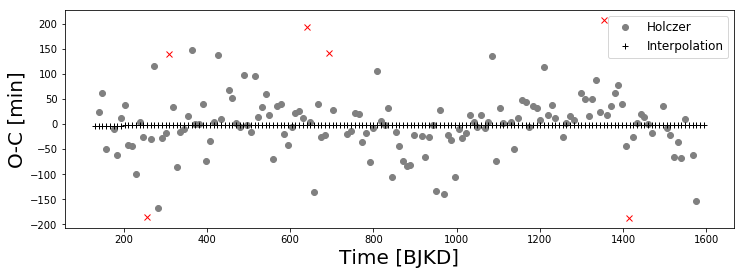

In [13]:
for npl in range(NPL):
    try:
        # fit a linear ephemeris 
        pfit  = np.polyfit(holczer_inds[npl], holczer_tts[npl], 1)
        ephem = np.polyval(pfit, holczer_inds[npl])


        # put fitted epoch in range (TIME_START, TIME_START + PERIOD)
        hper, hepoch = pfit

        if hepoch < TIME_START:
            adj = 1 + (TIME_START - hepoch)//hper
            hepoch += adj*hper       

        if hepoch > (TIME_START + hper):
            adj = (hepoch - TIME_START)//hper
            hepoch -= adj*hper      

        hephem = np.arange(hepoch, TIME_END, hper)        
        hinds  = np.array(np.round((hephem-hepoch)/hper),dtype='int')


        # calculate OMC and flag outliers
        xtime = np.copy(holczer_tts[npl])
        yomc  = (holczer_tts[npl] - ephem)

        ymed = ndimage.median_filter(yomc, size=5, mode="mirror")
        out  = np.abs(yomc-ymed)/astropy.stats.mad_std(yomc-ymed) > 5.0


        # determine best OMC model
        best_omc = choose_omc_model(xtime, yomc)

        N = int(best_omc[0])
        K = int(best_omc[1])
        theta = best_omc[2:]

        htts = hephem + omc_model(theta, hephem, N, K)

        holczer_inds[npl] = np.copy(hinds)
        holczer_tts[npl] = np.copy(htts)

        # plot the OMC
        plt.figure(figsize=(12,4))
        plt.plot(xtime[~out], yomc[~out]*24*60, 'o', c="grey", label="Holczer")
        plt.plot(xtime[out], yomc[out]*24*60, "rx")
        plt.plot(htts, (htts-hephem)*24*60, "k+", label="Interpolation")
        plt.xlabel("Time [BJKD]", fontsize=20)
        plt.ylabel("O-C [min]", fontsize=20)
        plt.legend(fontsize=12)
        plt.savefig(FIGURE_DIR + TARGET + "_holczer_ttvs_" + str(npl) + ".pdf")
        plt.show()
        
    except:
        pass

In [14]:
# check if Holczer TTVs exist, and if so, replace the linear ephemeris
for npl, p in enumerate(planets):
    match = np.isclose(holczer_pers, p.period, rtol=0.1, atol=DURS.max())
    
    if np.sum(match) == 1:
        loc = np.squeeze(np.where(match))
    
        hinds = holczer_inds[loc]
        htts  = holczer_tts[loc]
        
        tt_delta = htts.min() - p.tts.min()
        ind_delta = int(np.floor((tt_delta + 0.5*p.period)/p.period))
        
        p.tts[hinds + ind_delta] = np.copy(htts)
        
    if np.sum(match) > 1:
        raise ValueError("Something has gone wrong matching periods between DR25 and Holczer+ 2016")    
    
    ephem = np.polyval(np.polyfit(p.index, p.tts, 1), p.index)

# Detrend the lightcurves

In [17]:
# reset to raw data

if MISSION == 'Kepler':
    try:
        sc_data = detrend.cleanup_lkfc(sc_rawdata, KIC)

        sc_quarters = []
        for i, scd in enumerate(sc_data):
            sc_quarters.append(scd.quarter)    
    
    except:
        pass
    
    
    try:
        lc_data = detrend.cleanup_lkfc(lc_rawdata, KIC)

        lc_quarters = []
        for i, lcd in enumerate(lc_data):
            lc_quarters.append(lcd.quarter)
            
    except:
        pass
        

        
elif MISSION == 'Simulated':
    sc_quarters = []
    for i, scrd in enumerate(sc_rawdata):
        sc_quarters.append(scrd.quarter)
        
    order = np.argsort(sc_quarters)    
    sc_data = lk.LightCurveCollection([sc_rawdata_list[o] for o in order])
            

    lc_quarters = []
    for i, lcrd in enumerate(lc_rawdata):
        lc_quarters.append(lcrd.quarter)
        
    order = np.argsort(lc_quarters)    
    lc_data = lk.LightCurveCollection([lc_rawdata_list[o] for o in order])

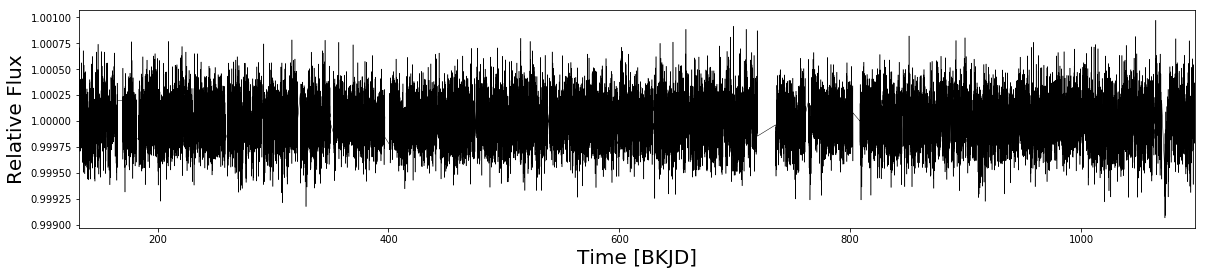

In [18]:
# clean up the LONG CADENCE data
for i, lcq in enumerate(lc_data):
    lcq = detrend.remove_flagged_cadences(lcq)
    lcq = detrend.clip_outliers(lcq, kernel_size=13, sigma_upper=5.0, sigma_lower=5.0)
    lc_data[i] = lcq

# broadcast quarter and channel integers into arrays (for convenient use after stitching)
for i, lcq in enumerate(lc_data):
    lcq.quarter = lcq.quarter*np.ones(len(lcq.time))
    lcq.channel = lcq.channel*np.ones(len(lcq.time))

    
if len(lc_data) > 0:
    # combine quarters into a single LiteCurve
    lc = detrend.stitch_lkc(lc_data)
    
    # make a mask where planets transit
    lc_mask = np.zeros((NPL,len(lc.time)),dtype='bool')
    for npl, p in enumerate(planets):
        lc_mask[npl] = detrend.make_transitmask(lc.time, p.tts, p.duration, masksize=1.5)

    lc.mask = deepcopy(lc_mask)
    
    # plot the non-detrended data
    plt.figure(figsize=(20,4))
    plt.plot(lc.time, lc.flux, c="k", lw=0.5)
    plt.xlim(lc.time.min(), lc.time.max())
    plt.xlabel('Time [BKJD]', fontsize=20)
    plt.ylabel('Relative Flux', fontsize=20)
    plt.show()
    
else:
    lc = None

optimizing logp for variables: [logvar, flux0, exp_amp, logtau, mix, log_deltaQ, log_Q0_off, log_per_off, log_amp]
296it [00:04, 59.21it/s, logp=5.905601e+04]
message: Desired error not necessarily achieved due to precision loss.
logp: 58021.410601324475 -> 59056.008135270764
optimizing logp for variables: [logvar, flux0, exp_amp, logtau, mix, log_deltaQ, log_Q0_off, log_per_off, log_amp]
335it [00:04, 69.61it/s, logp=7.850112e+04]
message: Desired error not necessarily achieved due to precision loss.
logp: 76835.3174998225 -> 78501.11827085887
optimizing logp for variables: [logvar, flux0, exp_amp, logtau, mix, log_deltaQ, log_Q0_off, log_per_off, log_amp]
267it [00:03, 74.42it/s, logp=6.622435e+04] 
message: Desired error not necessarily achieved due to precision loss.
logp: 65000.41762471945 -> 66224.35330120844
optimizing logp for variables: [logvar, flux0, exp_amp, logtau, mix, log_deltaQ, log_Q0_off, log_per_off, log_amp]
324it [00:04, 80.37it/s, logp=5.908769e+04]
message: Desir

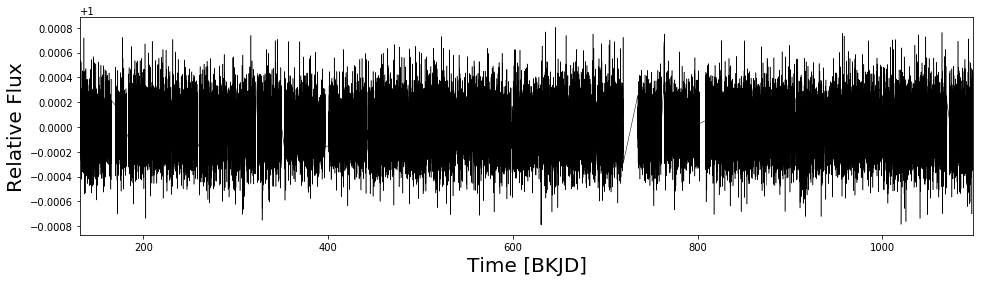

In [19]:
if lc is not None:    
    # detrend
    break_tolerance = int(DURS.max()/(LCIT/60/24)*5/2)
    min_period = 5*DURS.max()
    
    lc = detrend.flatten_with_gp(lc, break_tolerance=break_tolerance, min_period=min_period)

    # determine seasons
    lc.season = lc.quarter % 4

    # plot detrended data
    plt.figure(figsize=(16,4))
    plt.plot(lc.time, lc.flux, c='k', lw=0.5)
    plt.xlim(lc.time.min(), lc.time.max())
    plt.xlabel('Time [BKJD]', fontsize=20)
    plt.ylabel('Relative Flux', fontsize=20)
    plt.savefig(FIGURE_DIR + TARGET + '_long_cadence_flux.pdf', bbox_inches='tight')
    plt.show()

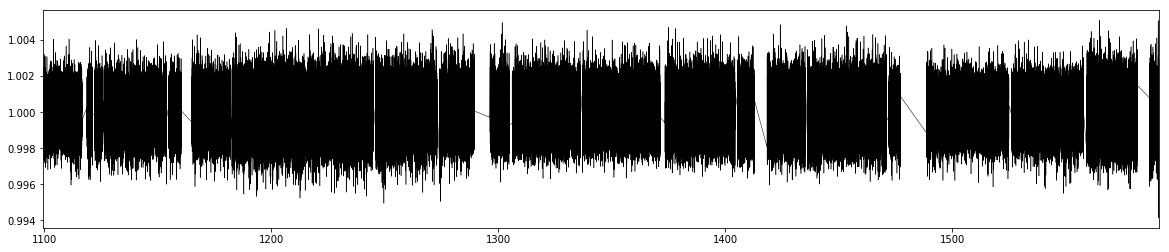

In [20]:
# clean up the SHORT CADENCE data
for i, scq in enumerate(sc_data):
    scq = detrend.remove_flagged_cadences(scq)
    scq = detrend.clip_outliers(scq, kernel_size=13, sigma_upper=5.0, sigma_lower=5.0)
    sc_data[i] = scq

# broadcast quarter and channel integers into arrays (for convenient use after stitching)
for i, scq in enumerate(sc_data):
    scq.quarter = scq.quarter*np.ones(len(scq.time))
    scq.channel = scq.channel*np.ones(len(scq.time))

    
if len(sc_data) > 0:
    # combine quarters into a single LiteCurve
    sc = detrend.stitch_lkc(sc_data)
    
    # make a mask where planets transit
    sc_mask = np.zeros((NPL,len(sc.time)),dtype='bool')
    for npl, p in enumerate(planets):
        sc_mask[npl] = detrend.make_transitmask(sc.time, p.tts, p.duration, masksize=1.5)

    sc.mask = deepcopy(sc_mask)
    
    # plot the non-detrended data
    plt.figure(figsize=(20,4))
    plt.plot(sc.time, sc.flux, c="k", lw=0.5)
    plt.xlim(sc.time.min(), sc.time.max())
    plt.show()
    
else:
    sc = None

optimizing logp for variables: [logvar, flux0, exp_amp, logtau, mix, log_deltaQ, log_Q0_off, log_per_off, log_amp]
226it [00:34,  6.85it/s, logp=9.118931e+05]
message: Desired error not necessarily achieved due to precision loss.
logp: 910293.3638714227 -> 911893.0819009913
optimizing logp for variables: [logvar, flux0, exp_amp, logtau, mix, log_deltaQ, log_Q0_off, log_per_off, log_amp]
374it [01:03,  5.88it/s, logp=1.042078e+06]
message: Optimization terminated successfully.
logp: 1040262.738055495 -> 1042077.517817874
optimizing logp for variables: [logvar, flux0, exp_amp, logtau, mix, log_deltaQ, log_Q0_off, log_per_off, log_amp]
249it [00:42,  5.75it/s, logp=1.045321e+06]
message: Desired error not necessarily achieved due to precision loss.
logp: 1043501.4422361235 -> 1045320.6027081151


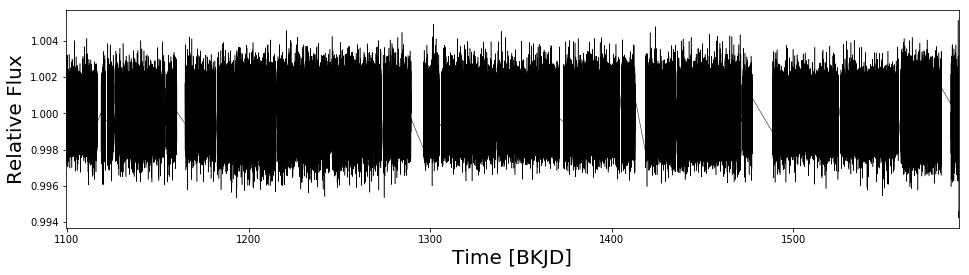

In [21]:
if sc is not None:    
    # detrend
    break_tolerance = int(DURS.max()/(SCIT/3600/24)*5/2)
    min_period = 5*DURS.max()
    
    sc = detrend.flatten_with_gp(sc, break_tolerance=break_tolerance, min_period=min_period)

    # determine seasons
    sc.season = sc.quarter % 4

    # plot detrended data
    plt.figure(figsize=(16,4))
    plt.plot(sc.time, sc.flux, c='k', lw=0.5)
    plt.xlim(sc.time.min(), sc.time.max())
    plt.xlabel('Time [BKJD]', fontsize=20)
    plt.ylabel('Relative Flux', fontsize=20)
    plt.savefig(FIGURE_DIR + TARGET + '_short_cadence_flux.pdf', bbox_inches='tight')
    plt.show()

# Make individual mask for where each planet transits
### These masks have width 1.5 transit durations, which may be wider than the masks used for detrending

In [22]:
print('Making transit masks')
try:
    sc_mask = np.zeros((NPL,len(sc.time)),dtype='bool')
    for npl, p in enumerate(planets):
        sc_mask[npl] = detrend.make_transitmask(sc.time, p.tts, p.duration, masksize=1.5)

    sc.mask = sc_mask

except:
    sc_mask = None

    
try:
    lc_mask = np.zeros((NPL,len(lc.time)),dtype='bool')
    for npl, p in enumerate(planets):
        lc_mask[npl] = detrend.make_transitmask(lc.time, p.tts, p.duration, masksize=1.5)
    
    lc.mask = lc_mask

except:
    lc_mask = None

Making transit masks


# Flag which transits have photometry coverage (quality = 1)

In [23]:
for npl, p in enumerate(planets):

    quality = []

    # cut out the stamps
    for i, t0 in enumerate(p.tts):
        try:
            neartransit_sc = np.abs(sc.time - t0)/p.duration < 1.5
            neartransit_lc = np.abs(lc.time - t0)/p.duration < 1.5
        
            quality.append((np.sum(neartransit_sc) + np.sum(neartransit_lc)) > 0)
                        
        except:
            neartransit = np.abs(lc.time - t0)/p.duration < 1.5
            quality.append(np.sum(neartransit) > 0)
        
    p.quality = quality

# Flag which transits overlap (overlap = 1)

In [24]:
# identify overlapping transits
dur_max = np.max(DURS)
overlap = []

for i in range(NPL):
    overlap.append(np.zeros(len(planets[i].tts), dtype='bool'))
    
    for j in range(NPL):
        if i != j:
            for ttj in planets[j].tts:
                overlap[i] += np.abs(planets[i].tts - ttj) < dur_max
                
    planets[i].overlap = overlap[i]

# Set dummy values for GP priors

In [25]:
print('Setting dummy values for GP priors\n')
gp_priors = []

for i in range(4):
    # these are dummy values that effectively create a zero-amplitude kernel
    gpi = {}
    gpi['logw0'] = [np.log(2*pi/(5*DURS.max()))]
    gpi['logSw4'] = [-40.]
    gpi['logQ'] = [np.log(1/np.sqrt(2))]
    gp_priors.append(gpi)

Setting dummy values for GP priors



# Grab the relevant data and starting transit parameters

In [26]:
# grab data near transits for each quarter
all_time = []
all_flux = []
all_error = []
all_dtype = []

lc_flux = []
sc_flux = []

if sc is not None:
    for q in range(18):
        if np.isin(q, sc.quarter)*np.isin(q, lc.quarter):
            raise ValueError("Double counting data in both short and long cadence")


        elif np.isin(q, sc.quarter):
            use = (sc.mask.sum(axis=0) > 0)*(sc.quarter == q)

            if np.sum(use) > 45:
                all_time.append(sc.time[use])
                all_flux.append(sc.flux[use])
                all_error.append(sc.error[use])
                all_dtype.append('short')

                sc_flux.append(sc.flux[use])
                
            else:
                all_time.append(None)
                all_flux.append(None)
                all_error.append(None)
                all_dtype.append('none')


        elif np.isin(q, lc.quarter):
            use = (lc.mask.sum(axis=0) > 0)*(lc.quarter == q)
            
            if np.sum(use) > 3:
                all_time.append(lc.time[use])
                all_flux.append(lc.flux[use])
                all_error.append(lc.error[use])
                all_dtype.append('long')

                lc_flux.append(lc.flux[use])
                
            else:
                all_time.append(None)
                all_flux.append(None)
                all_error.append(None)
                all_dtype.append('none')


        else:
            all_time.append(None)
            all_flux.append(None)
            all_error.append(None)
            all_dtype.append('none')
            
else:
    for q in range(18):
        if np.isin(q, lc.quarter):
            use = (lc.mask.sum(axis=0) > 0)*(lc.quarter == q)

            if np.sum(use) > 3:
                all_time.append(lc.time[use])
                all_flux.append(lc.flux[use])
                all_error.append(lc.error[use])
                all_dtype.append('long')

                lc_flux.append(lc.flux[use])
                
            else:
                all_time.append(None)
                all_flux.append(None)
                all_error.append(None)
                all_dtype.append('none')


        else:
            all_time.append(None)
            all_flux.append(None)
            all_error.append(None)
            all_dtype.append('none')



# check which quarters have data
good = (np.array(all_dtype) == 'short') + (np.array(all_dtype) == 'long')
quarters = np.arange(18)[good]
nq = len(quarters)


# make some linear flux arrays (for convenience use laster)
try: sc_flux_lin = np.hstack(sc_flux)
except: sc_flux_lin = np.array([])
    
try: lc_flux_lin = np.hstack(lc_flux)
except: lc_flux_lin = np.array([])
    
try:
    good_flux = np.hstack([sc_flux_lin, lc_flux_lin])
except:
    try:
        good_flux = np.hstack(sc_flux)
    except:
        good_flux = np.hstack(lc_flux)

In [27]:
# pull basic transit parameters
epochs    = np.zeros(NPL)
periods   = np.zeros(NPL)
depths    = np.zeros(NPL)
durations = np.zeros(NPL)
impacts   = np.zeros(NPL)

for npl, p in enumerate(planets):
    epochs[npl]    = p.epoch
    periods[npl]   = p.period
    depths[npl]    = p.depth
    durations[npl] = p.duration
    impacts[npl]   = p.impact

radii = np.sqrt(depths)*RSTAR

In [28]:
print('')
print('cumulative runtime = ', int(timer() - global_start_time), 's')
print('')


cumulative runtime =  352 s



# (1) Fit POLYNOMIAL TTVs

The TTV model is built as perturbations from fixed (i.e. invariant) transit times. These transit times ("FIXED_TTSS") are not varied during model fitting. If TTVs are available from Holczer+ 2016, these are used; if not, the fixed transit times determined from a linear ephemeris using Kepler DR25 epoch and period.

Long-term, secular TTVs are parameterized as 3rd order Legendre polynomials as functions of dimensionless variable ("x") in the range (-1,1)

Unlike the transit time and index values attached to each Planet object, there may be gaps in the FIXED_TTS vector where there is no available photometric data.

In [29]:
print('\n(1) Fitting POLYNOMIAL TTV model')


(1) Fitting POLYNOMIAL TTV model


In [30]:
# pull transit_inds (zero indexed) and calculate initial Keplerian ephemeris
num_transits  = np.zeros(NPL)
transit_inds  = []

FIXED_TTS = []

for npl, p in enumerate(planets):
    transit_inds.append((p.index - p.index.min())[p.quality])
    FIXED_TTS.append(np.copy(p.tts)[p.quality])
    
    num_transits[npl] = len(transit_inds[npl])
    
# use Legendre polynomials for better orthogonality; "x" is in the range (-1,1)
Leg0 = []
Leg1 = []
Leg2 = []
Leg3 = []
t = []

# this assumes a baseline in the range (TIME_START,TIME_END)
for npl, p in enumerate(planets):    
    t.append(p.epoch + transit_inds[npl]*p.period)
    x = 2*(t[npl]-TIME_START)/(TIME_END-TIME_START) - 1

    Leg0.append(np.ones_like(x))
    Leg1.append(x.copy())
    Leg2.append(0.5*(3*x**2 - 1))
    Leg3.append(0.5*(5*x**3 - 3*x))

In [31]:
with pm.Model() as poly_model:
    # stellar parameters (limb darkening using Kipping 2013)
    u = exo.distributions.QuadLimbDark('u', testval=np.array([U1,U2]))

    Rstar = pm.Bound(pm.Normal, lower=RSTAR-3*RSTAR_ERR, upper=RSTAR+3*RSTAR_ERR)('Rstar', mu=RSTAR, sd=RSTAR_ERR)
    Mstar = pm.Bound(pm.Normal, lower=MSTAR-3*MSTAR_ERR, upper=MSTAR+3*MSTAR_ERR)('Mstar', mu=MSTAR, sd=MSTAR_ERR)

    
    # planetary parameters (impact parameter using Espinoza 2018)
    logr = pm.Uniform('logr', lower=np.log(0.0003), upper=np.log(0.3), testval=np.log(radii), shape=NPL)
    rp   = pm.Deterministic('rp', T.exp(logr))
    
    b  = exo.distributions.ImpactParameter('b', ror=rp/Rstar, testval=impacts, shape=NPL)
    
    
    # polynomial TTV parameters    
    C0 = pm.Normal('C0', mu=0.0, sd=durations/2, shape=NPL)
    C1 = pm.Normal('C1', mu=0.0, sd=durations/2, shape=NPL)
    C2 = []
    C3 = []
    
    for npl in range(NPL):
        if len(transit_inds[npl]) > 7:
            C2.append(pm.Normal('C2_{0}'.format(npl), mu=0.0, sd=durations[npl]/4))
        else:
            C2.append(0.)
            
        if len(transit_inds[npl]) > 15:
            C3.append(pm.Normal('C3_{0}'.format(npl), mu=0.0, sd=durations[npl]/4))
        else:
            C3.append(0.)
    

    transit_times = []
    for npl in range(NPL):
        transit_times.append(pm.Deterministic('tts_{0}'.format(npl), \
                                              FIXED_TTS[npl] + \
                                              C0[npl]*Leg0[npl] + C1[npl]*Leg1[npl] + \
                                              C2[npl]*Leg2[npl] + C3[npl]*Leg3[npl]))
    
    
    # set up stellar model and planetary orbit
    exoSLC = exo.StarryLightCurve(u)
    orbit  = exo.orbits.TTVOrbit(transit_times=transit_times, transit_inds=transit_inds, \
                                 b=b, r_star=Rstar, m_star=Mstar)
    
    # track period and epoch
    T0 = pm.Deterministic('T0', orbit.t0)
    P  = pm.Deterministic('P', orbit.period)
    
    
    # build the GP kernel using a different noise model for each season
    logSw4 = [None]*4
    logw0  = [None]*4
    logQ   = [None]*4
    
    kernel  = [None]*4
    
    for i in range(4):
        gpi = gp_priors[i]
        
        try:
            logSw4[i] = pm.Normal('logSw4_{0}'.format(i), mu=gpi['logSw4'][0], sd=gpi['logSw4'][1])
        except:
            logSw4[i] = gpi['logSw4'][0]
            
        try:
            logw0[i] = pm.Normal('logw0_{0}'.format(i), mu=gpi['logw0'][0], sd=gpi['logw0'][1])
        except:
            logw0[i] = gpi['logw0'][0]

        try:
            logQ[i] = pm.Normal('logQ_{0}'.format(i), mu=gpi['logQ'][0], sd=gpi['logQ'][1])
        except:
            logQ[i] = gpi['logQ'][0]

        
        kernel[i] = exo.gp.terms.SHOTerm(log_Sw4=logSw4[i], log_w0=logw0[i], log_Q=logQ[i])
        
        
    # nuissance parameters
    flux0 = pm.Normal('flux0', mu=1.0, sd=np.std(good_flux))

    if len(sc_flux_lin) > 1:
        logvar = pm.Normal('logvar', mu=np.log(np.var(sc_flux_lin)), sd=np.log(4))
    else:
        logvar = pm.Normal('logvar', mu=np.log(np.var(lc_flux_lin)*30), sd=np.log(4))
    
    
    # now evaluate the model for each quarter
    light_curves       = [None]*nq
    summed_light_curve = [None]*nq
    model_flux         = [None]*nq
    
    gp      = [None]*nq
    gp_pred = [None]*nq
    
    
    for j, q in enumerate(quarters):
        # set oversampling factor
        if all_dtype[q] == 'short':
            oversample = 1
        elif all_dtype[q] == 'long':
            oversample = 15
            
        # calculate light curves
        light_curves[j] = exoSLC.get_light_curve(orbit=orbit, r=rp, t=all_time[q], oversample=oversample)
        summed_light_curve[j] = pm.math.sum(light_curves[j], axis=-1) + flux0*T.ones(len(all_time[q]))
        model_flux[j] = pm.Deterministic('model_flux_{0}'.format(j), summed_light_curve[j])
        
        # here's the GP (w/ kernel by season)
        if all_dtype[q] == 'short':
            gp[j] = exo.gp.GP(kernel[q%4], all_time[q], T.exp(logvar)*T.ones(len(all_time[q])))
            
        elif all_dtype[q] == 'long':
            gp[j] = exo.gp.GP(kernel[q%4], all_time[q], T.exp(logvar)/30*T.ones(len(all_time[q])))
            
        else:
            raise ValueError("Cadence data type must be 'short' or 'long'")


        # add custom potential (log-prob fxn) with the GP likelihood
        pm.Potential('obs_{0}'.format(j), gp[j].log_likelihood(all_flux[q] - model_flux[j]))


        # track GP prediction
        gp_pred[j] = pm.Deterministic('gp_pred_{0}'.format(j), gp[j].predict())

In [32]:
with poly_model:
    poly_map = exo.optimize(start=poly_model.test_point, vars=[flux0, logvar])
    poly_map = exo.optimize(start=poly_model.test_point, vars=[b])
    poly_map = exo.optimize(start=poly_map, vars=[u, Mstar])
    poly_map = exo.optimize(start=poly_map, vars=[C0, C1])
    
    for npl in range(NPL):
        try: poly_map = exo.optimize(start=poly_map, vars=[C2[npl], C3[npl]])
        except:
            try: poly_map = exo.optimize(start=poly_map, vars=[C2[npl]])
            except: pass

    poly_map = exo.optimize(start=poly_map)

optimizing logp for variables: [logvar, flux0]
78it [00:06, 12.44it/s, logp=6.132573e+05]
message: Desired error not necessarily achieved due to precision loss.
logp: 613157.32598983 -> 613257.265468222
optimizing logp for variables: [b, logr, Rstar]
147it [00:15,  9.71it/s, logp=6.135013e+05]
message: Desired error not necessarily achieved due to precision loss.
logp: 613157.32598983 -> 613501.2662281288
optimizing logp for variables: [Mstar, u]
31it [00:07,  4.06it/s, logp=6.135057e+05]
message: Desired error not necessarily achieved due to precision loss.
logp: 613501.2662281288 -> 613505.673889549
optimizing logp for variables: [C1, C0]
67it [00:12,  5.42it/s, logp=6.135076e+05]
message: Desired error not necessarily achieved due to precision loss.
logp: 613505.673889549 -> 613507.553248755
optimizing logp for variables: [C3_0, C2_0]
86it [00:07, 11.72it/s, logp=6.135561e+05]
message: Desired error not necessarily achieved due to precision loss.
logp: 613507.553248755 -> 613556.070

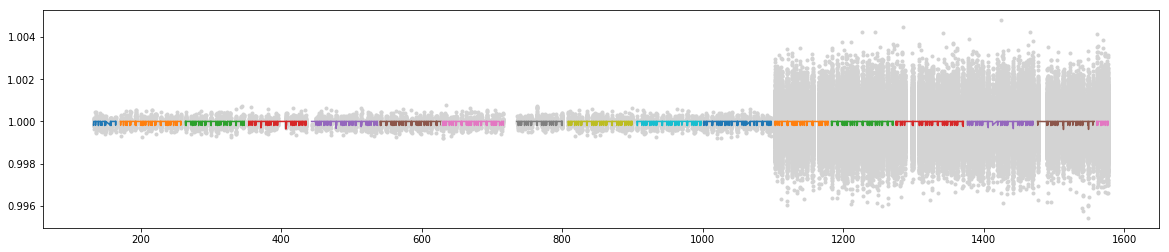

In [33]:
# grab the model flux and gp prediction
model_flux = []
gp_pred = []

for j, q in enumerate(quarters):
    model_flux.append(poly_map['model_flux_{0}'.format(j)])
    gp_pred.append(poly_map['gp_pred_{0}'.format(j)])


# plot the model lightcurve
plt.figure(figsize=(20,4))
for j, q in enumerate(quarters):
    plt.plot(all_time[q], all_flux[q], '.', color='lightgrey')
    plt.plot(all_time[q], model_flux[j] + gp_pred[j])
plt.show()

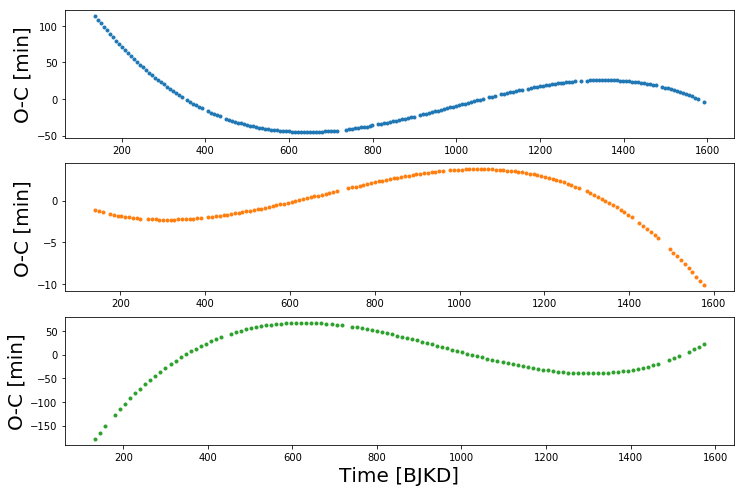

In [34]:
# grab transit times and ephemeris
poly_transit_times = []
poly_ephemeris = []

for npl, p in enumerate(planets):
    poly_transit_times.append(poly_map['tts_{0}'.format(npl)])
    poly_ephemeris.append(poly_map['P'][npl]*transit_inds[npl] + poly_map['T0'][npl])

    
# plot the OMC TTVs
fig, axes = plt.subplots(NPL, figsize=(12,8))

for npl, p in enumerate(planets):
    xtime = poly_transit_times[npl]
    yomc  = (poly_transit_times[npl] - poly_ephemeris[npl])*24*60
    
    axes[npl].plot(xtime, yomc, '.', c='C{0}'.format(npl))
    axes[npl].set_ylabel('O-C [min]', fontsize=20)
axes[NPL-1].set_xlabel('Time [BJKD]', fontsize=20)
plt.savefig(FIGURE_DIR + TARGET + '_ttvs_poly.pdf', bbox_inches='tight')
plt.show()

In [35]:
print('')
print('cumulative runtime = ', int(timer() - global_start_time), 's')
print('')


cumulative runtime =  646 s



# (2) Fit independent TTVs

In [36]:
print('\n(2) Fitting INDEPENDENT TTV model')


(2) Fitting INDEPENDENT TTV model


In [37]:
rp = poly_map['rp']
b  = poly_map['b']

Rstar = poly_map['Rstar']
Mstar = poly_map['Mstar']
u = poly_map['u']

In [38]:
with pm.Model() as indep_model:
    # transit times
    tt_offset = []
    transit_times = []
    for npl in range(NPL):
        tt_offset.append(pm.StudentT('tt_offset_{0}'.format(npl), nu=2, shape=len(poly_transit_times[npl])))
        
        transit_times.append(pm.Deterministic('tts_{0}'.format(npl), \
                                              poly_transit_times[npl] + tt_offset[npl]*durations[npl]/3))
    
    # set up stellar model and planetary orbit
    exoSLC = exo.StarryLightCurve(u)
    orbit  = exo.orbits.TTVOrbit(transit_times=transit_times, transit_inds=transit_inds, \
                                 b=b, r_star=Rstar, m_star=Mstar)
    
    # track period and epoch
    T0 = pm.Deterministic('T0', orbit.t0)
    P  = pm.Deterministic('P', orbit.period)
    
    
    # build the GP kernel using a different noise model for each season
    logSw4 = [None]*4
    logw0  = [None]*4
    logQ   = [None]*4
    
    kernel  = [None]*4
    
    for i in range(4):
        gpi = gp_priors[i]
        
        try:
            logSw4[i] = pm.Normal('logSw4_{0}'.format(i), mu=gpi['logSw4'][0], sd=gpi['logSw4'][1])
        except:
            logSw4[i] = gpi['logSw4'][0]
            
        try:
            logw0[i] = pm.Normal('logw0_{0}'.format(i), mu=gpi['logw0'][0], sd=gpi['logw0'][1])
        except:
            logw0[i] = gpi['logw0'][0]

        try:
            logQ[i] = pm.Normal('logQ_{0}'.format(i), mu=gpi['logQ'][0], sd=gpi['logQ'][1])
        except:
            logQ[i] = gpi['logQ'][0]

        
        kernel[i] = exo.gp.terms.SHOTerm(log_Sw4=logSw4[i], log_w0=logw0[i], log_Q=logQ[i])
        
        
        
    # nuissance parameters
    flux0 = pm.Normal('flux0', mu=1.0, sd=np.std(good_flux))

    if len(sc_flux_lin) > 1:
        logvar = pm.Normal('logvar', mu=np.log(np.var(sc_flux_lin)), sd=np.log(4))
    else:
        logvar = pm.Normal('logvar', mu=np.log(np.var(lc_flux_lin)*30), sd=np.log(4))
    
    
    # now evaluate the model for each quarter
    light_curves       = [None]*nq
    summed_light_curve = [None]*nq
    model_flux         = [None]*nq
    
    gp      = [None]*nq
    gp_pred = [None]*nq
    
    
    for j, q in enumerate(quarters):
        # set oversampling factor
        if all_dtype[q] == 'short':
            oversample = 1
        elif all_dtype[q] == 'long':
            oversample = 15
            
        # calculate light curves
        light_curves[j] = exoSLC.get_light_curve(orbit=orbit, r=rp, t=all_time[q], oversample=oversample)
        summed_light_curve[j] = pm.math.sum(light_curves[j], axis=-1) + flux0*T.ones(len(all_time[q]))
        model_flux[j] = pm.Deterministic('model_flux_{0}'.format(j), summed_light_curve[j])
        
        # here's the GP (w/ kernel by season)
        if all_dtype[q] == 'short':
            gp[j] = exo.gp.GP(kernel[q%4], all_time[q], T.exp(logvar)*T.ones(len(all_time[q])))
            
        elif all_dtype[q] == 'long':
            gp[j] = exo.gp.GP(kernel[q%4], all_time[q], T.exp(logvar)/30*T.ones(len(all_time[q])))
            
        else:
            raise ValueError("Cadence data type must be 'short' or 'long'")


        # add custom potential (log-prob fxn) with the GP likelihood
        pm.Potential('obs_{0}'.format(j), gp[j].log_likelihood(all_flux[q] - model_flux[j]))


        # track GP prediction
        gp_pred[j] = pm.Deterministic('gp_pred_{0}'.format(j), gp[j].predict())

In [39]:
with indep_model:
    indep_map = exo.optimize(start=indep_model.test_point)

optimizing logp for variables: [logvar, flux0, tt_offset_2, tt_offset_1, tt_offset_0]
918it [01:26, 11.06it/s, logp=6.134287e+05]
message: Desired error not necessarily achieved due to precision loss.
logp: 613197.6495877436 -> 613428.6607140966


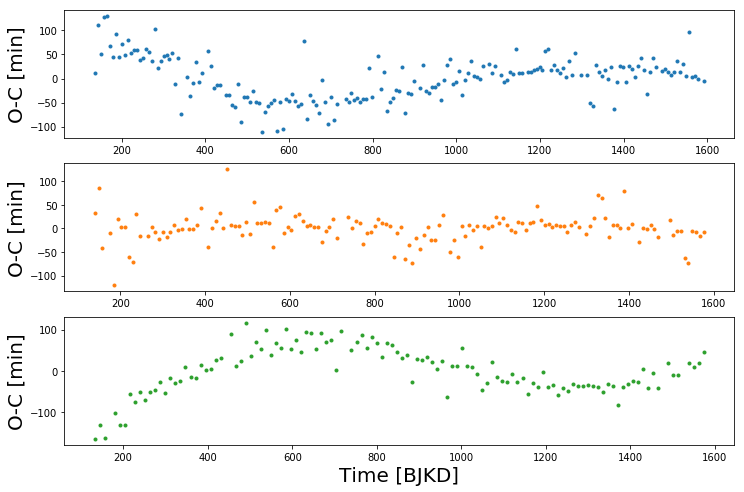

In [40]:
indep_transit_times = []
indep_ephemeris = []

for npl in range(NPL):
    indep_transit_times.append(indep_map['tts_{0}'.format(npl)])
    indep_ephemeris.append(indep_map['P'][npl]*transit_inds[npl] + indep_map['T0'][npl])
    
    
fig, axes = plt.subplots(NPL, figsize=(12,8))

for npl, p in enumerate(planets):
    xtime = indep_transit_times[npl]
    yomc  = (indep_transit_times[npl] - indep_ephemeris[npl])*24*60
    
    axes[npl].plot(xtime, yomc, '.', c='C{0}'.format(npl))
    axes[npl].set_ylabel('O-C [min]', fontsize=20)
axes[NPL-1].set_xlabel('Time [BJKD]', fontsize=20)
plt.savefig(FIGURE_DIR + TARGET + '_ttvs_indep.pdf', bbox_inches='tight')
plt.show()

In [41]:
# get estimate of ttv amplitude and a reasonable buffer
ttv_amps   = np.zeros(NPL)
ttv_buffer = np.zeros(NPL)

for npl in range(NPL):
    # estimate TTV amplitude
    ttv_amps[npl] = astropy.stats.mad_std(indep_transit_times[npl] - indep_ephemeris[npl])

    # based on scatter in independent times, set threshold so not even one outlier is expected
    N   = len(transit_inds[npl])
    eta = np.max([3., stats.norm.interval((N-1)/N)[1]])

    ttv_buffer[npl] = eta*ttv_amps[npl]

In [42]:
# Save fixed ephemeris and independent TTV measurements to a text file
for npl in range(NPL):
    data_out = np.vstack([transit_inds[npl], indep_ephemeris[npl]]).swapaxes(0,1)
    fname_out = QUICK_TTV_DIR + TARGET + "_{:02d}".format(npl) + "_fixed_ephemeris.txt"
    
    np.savetxt(fname_out, data_out, fmt=('%1d', '%.8f'), delimiter='\t')
    
    
    data_out  = np.vstack([transit_inds[npl], indep_transit_times[npl]]).swapaxes(0,1)
    fname_out = QUICK_TTV_DIR + TARGET + '_{:02d}'.format(npl) + '_map_indep_ttvs.txt'
    
    np.savetxt(fname_out, data_out, fmt=('%1d', '%.8f'), delimiter='\t')

In [43]:
print('')
print('cumulative runtime = ', int(timer() - global_start_time), 's')
print('')


cumulative runtime =  767 s



# Detrend again with better estimates of transit timing

In [ ]:
# reset to raw data

if MISSION == 'Kepler':
    try:
        sc_data = detrend.cleanup_lkfc(sc_rawdata, KIC)

        sc_quarters = []
        for i, scd in enumerate(sc_data):
            sc_quarters.append(scd.quarter)    
    
    except:
        pass
    
    
    try:
        lc_data = detrend.cleanup_lkfc(lc_rawdata, KIC)

        lc_quarters = []
        for i, lcd in enumerate(lc_data):
            lc_quarters.append(lcd.quarter)
            
    except:
        pass
        

        
elif MISSION == 'Simulated':
    sc_quarters = []
    for i, scrd in enumerate(sc_rawdata):
        sc_quarters.append(scrd.quarter)
        
    order = np.argsort(sc_quarters)    
    sc_data = lk.LightCurveCollection([sc_rawdata_list[o] for o in order])
            

    lc_quarters = []
    for i, lcrd in enumerate(lc_rawdata):
        lc_quarters.append(lcrd.quarter)
        
    order = np.argsort(lc_quarters)    
    lc_data = lk.LightCurveCollection([lc_rawdata_list[o] for o in order])

In [ ]:
# clean up the LONG CADENCE data
for i, lcq in enumerate(lc_data):
    lcq = detrend.remove_flagged_cadences(lcq)
    lcq = detrend.clip_outliers(lcq, kernel_size=13, sigma_upper=5.0, sigma_lower=5.0)
    lc_data[i] = lcq

# broadcast quarter and channel integers into arrays (for convenient use after stitching)
for i, lcq in enumerate(lc_data):
    lcq.quarter = lcq.quarter*np.ones(len(lcq.time))
    lcq.channel = lcq.channel*np.ones(len(lcq.time))

    
if len(lc_data) > 0:
    # combine quarters into a single LiteCurve
    lc = detrend.stitch_lkc(lc_data)
    
    # make a mask where planets transit
    lc_mask = np.zeros((NPL,len(lc.time)),dtype='bool')
    for npl, p in enumerate(planets):
        masksize = (p.duration + 2*ttv_buffer[npl] + 1/24) / p.duration / 2
        masksize = np.max([masksize, 2/3])
    
        lc_mask[npl] = detrend.make_transitmask(lc.time, p.tts, p.duration, masksize=masksize)

    lc.mask = deepcopy(lc_mask)
    
    # plot the non-detrended data
    plt.figure(figsize=(20,4))
    plt.plot(lc.time, lc.flux, c="k", lw=0.5)
    plt.xlim(lc.time.min(), lc.time.max())
    plt.show()
    
else:
    lc = None

In [ ]:
if lc is not None:    
    # detrend
    break_tolerance = int(DURS.max()/(LCIT/60/24)*5/2)
    min_period = 5*DURS.max()
    
    lc = detrend.flatten_with_gp(lc, break_tolerance=break_tolerance, min_period=min_period)

    # determine seasons
    lc.season = lc.quarter % 4

    # plot detrended data
    plt.figure(figsize=(16,4))
    plt.plot(lc.time, lc.flux, c='k', lw=0.5)
    plt.xlim(lc.time.min(), lc.time.max())
    plt.xlabel('Time [BKJD]', fontsize=20)
    plt.ylabel('Relative Flux', fontsize=20)
    plt.savefig(FIGURE_DIR + TARGET + '_long_cadence_flux.pdf', bbox_inches='tight')
    plt.show()

In [ ]:
# clean up the SHORT CADENCE data
for i, scq in enumerate(sc_data):
    scq = detrend.remove_flagged_cadences(scq)
    scq = detrend.clip_outliers(scq, kernel_size=13, sigma_upper=5.0, sigma_lower=5.0)
    sc_data[i] = scq

# broadcast quarter and channel integers into arrays (for convenient use after stitching)
for i, scq in enumerate(sc_data):
    scq.quarter = scq.quarter*np.ones(len(scq.time))
    scq.channel = scq.channel*np.ones(len(scq.time))

    
if len(sc_data) > 0:
    # combine quarters into a single LiteCurve
    sc = detrend.stitch_lkc(sc_data)
    
    # make a mask where planets transit
    sc_mask = np.zeros((NPL,len(sc.time)),dtype='bool')
    for npl, p in enumerate(planets):
        masksize = (p.duration + 2*ttv_buffer[npl] + 1/24) / p.duration / 2
        masksize = np.max([masksize, 2/3])

        sc_mask[npl] = detrend.make_transitmask(sc.time, p.tts, p.duration, masksize=masksize)

    sc.mask = deepcopy(sc_mask)
    
    # plot the non-detrended data
    plt.figure(figsize=(20,4))
    plt.plot(sc.time, sc.flux, c="k", lw=0.5)
    plt.xlim(sc.time.min(), sc.time.max())
    plt.show()
    
else:
    sc = None

In [ ]:
if sc is not None:    
    # detrend
    break_tolerance = int(DURS.max()/(SCIT/3600/24)*5/2)
    min_period = 5*DURS.max()
    
    sc = detrend.flatten_with_gp(sc, break_tolerance=break_tolerance, min_period=min_period)

    # determine seasons
    sc.season = sc.quarter % 4

    # plot detrended data
    plt.figure(figsize=(16,4))
    plt.plot(sc.time, sc.flux, c='k', lw=0.5)
    plt.xlim(sc.time.min(), sc.time.max())
    plt.xlabel('Time [BKJD]', fontsize=20)
    plt.ylabel('Relative Flux', fontsize=20)
    plt.savefig(FIGURE_DIR + TARGET + '_short_cadence_flux.pdf', bbox_inches='tight')
    plt.show()

# Make individual mask for where each planet transits
### These masks have width 1.5 transit durations, which may be wider than the masks used for detrending

In [ ]:
print('Making transit masks')
try:
    sc_mask = np.zeros((NPL,len(sc.time)),dtype='bool')
    for npl, p in enumerate(planets):
        sc_mask[npl] = detrend.make_transitmask(sc.time, p.tts, p.duration, masksize=1.5)

    sc.mask = sc_mask

except:
    sc_mask = None

    
try:
    lc_mask = np.zeros((NPL,len(lc.time)),dtype='bool')
    for npl, p in enumerate(planets):
        lc_mask[npl] = detrend.make_transitmask(lc.time, p.tts, p.duration, masksize=1.5)
    
    lc.mask = lc_mask

except:
    lc_mask = None

# Flag where there is data near transit (quality = 1)

In [ ]:
for npl, p in enumerate(planets):

    quality = []

    # cut out the stamps
    for i, t0 in enumerate(p.tts):
        try:
            neartransit_sc = np.abs(sc.time - t0)/p.duration < 1.5
            neartransit_lc = np.abs(lc.time - t0)/p.duration < 1.5
        
            quality.append((np.sum(neartransit_sc) + np.sum(neartransit_lc)) > 0)
                        
        except:
            neartransit = np.abs(lc.time - t0)/p.duration < 1.5
            quality.append(np.sum(neartransit) > 0)
        
    p.quality = quality

In [ ]:
print('')
print('cumulative runtime = ', int(timer() - global_start_time), 's')
print('')

# Make phase-folded transit plots

In [ ]:
for npl, p in enumerate(planets):
    tts = p.tts[p.quality*~p.overlap]
    
    
    if len(tts) == 0:
        print("No non-overlapping high quality transits found for planet {0} (P = {1} d)".format(npl, p.period))
    
    
    else:
        t_ = []
        f_ = []


        for t0 in tts:
            try:
                neartransit_sc = np.abs(sc.time - t0)/p.duration < 1.5
            except:
                neartransit_sc = None

            try:
                neartransit_lc = np.abs(lc.time - t0)/p.duration < 1.5
            except:
                neartransit_lc = None

            if (neartransit_lc is not None) and (np.sum(neartransit_lc) > 0):
                t_.append(lc.time[neartransit_lc] - t0)
                f_.append(lc.flux[neartransit_lc])

            if (neartransit_sc is not None) and (np.sum(neartransit_sc) > 0):
                t_.append(sc.time[neartransit_sc] - t0)
                f_.append(sc.flux[neartransit_sc])


        t_ = np.hstack(t_)
        f_ = np.hstack(f_)

        order = np.argsort(t_)
        t_ = t_[order]
        f_ = f_[order]

        f_bin = bin_data(t_, f_, LCIT/60/24/2)
        t_bin = bin_data(t_, t_, LCIT/60/24/2)

        plt.figure(figsize=(12,4))
        plt.plot(t_*24, f_, ".", c="lightgrey")
        plt.plot(t_bin*24, f_bin, "o", ms=5, color="C{0}".format(npl))
        plt.savefig(FIGURE_DIR + TARGET + '_{0:02d}_folded_transit_.pdf'.format(npl), bbox_inches='tight')
        plt.show()

# Generate and model empirical autocorrelation function (ACF)

In [ ]:
# generating figures inside imported modules creates issues with UChicago Midway RCC cluster
# it's easier to just define the function here in the main script

def plot_acf(xcor, acf_emp, acf_mod, xf, yf, freqs, target_name, season):
    """
    Docstring
    """
    fig = plt.figure(figsize=(20,5))

    plt.tight_layout()
    plt.subplots_adjust(wspace=0.8)

    ax = plt.subplot2grid(shape=(5,10), loc=(0,0), rowspan=3, colspan=7)
    ax.plot(xcor*24, acf_emp[0], color='lightgrey')
    ax.plot(xcor*24, acf_mod[0], c='red')
    ax.set_xlim(xcor.min()*24,xcor.max()*24)
    ax.set_xticks(np.arange(0,xcor.max()*24,2))
    ax.set_xticklabels([])
    ax.set_ylim(acf_emp.min()*1.1, acf_emp.max()*1.1)
    ax.set_ylabel('ACF', fontsize=20)
    ax.text(xcor.max()*24-0.15, acf_emp.max(), '%s, SEASON %d' %(target_name, season), va='top', ha='right', fontsize=20)


    ax = plt.subplot2grid(shape=(5,10), loc=(0,7), rowspan=5, colspan=3)
    ax.plot(xf/24/3600*1e3, yf, color='k', lw=0.5)
    for f in freqs:
        ax.axvline(f/24/3600*1e3, color='red', zorder=0, lw=3, alpha=0.3) 
    ax.set_xlim(xf.min()/24/3600*1e3, xf.max()/24/3600*1e3)
    ax.set_ylim(yf.min(),1.2*yf.max())
    ax.set_ylabel('Power', fontsize=20)
    ax.set_yticks([])
    ax.set_xlabel('Frequency [mHz]', fontsize=20)

    for i, sf in enumerate(np.sort(freqs)[::-1]):
        ax.text(xf.min()/24/3600*1e3+0.1, yf.max()*(1.1-0.1*i), '%.2f min' %(24*60/sf), fontsize=16)


    ax = plt.subplot2grid(shape=(5,10), loc=(3,0), rowspan=2, colspan=7)
    ax.plot(xcor*24, acf_emp[1], c='lightgrey')
    #ax.plot(xcor*24, acf_mod[1], c='red', lw=0.5)
    ax.set_xlim(xcor.min()*24,xcor.max()*24)
    ax.set_xticks(np.arange(0,xcor.max()*24,2))
    ax.set_xlabel('Lag time [hours]', fontsize=20)
    ax.set_ylabel('Residuals', fontsize=20)    
    
    return fig

In [ ]:
print('Generating autocorrelation function\n')

# set Npts from 5 x maximum transit duration
durations = np.zeros(NPL)
for npl, p in enumerate(planets):
    durations[npl] = p.duration
Npts = int(5*durations.max()*24*3600/SCIT)


# set cutoff between low and high frequency signals
fcut = 2/(LCIT/60/24)
fmin = 2/(5*durations.max())

# now estimate the ACF
acf_lag = []
acf_emp = []
acf_mod = []
acf_freqs = []


if sc is not None:
    for z in range(4):
        # make a mask where any planet transits
        scm = sc.mask.sum(axis=0) > 0

        # pull out a particular season
        use = sc.season == z
        scm = scm[use]

        if np.sum(use) > 0:
            sc_time = sc.time[use][~scm]
            sc_flux = sc.flux[use][~scm]
            sc_error = sc.error[use][~scm]
            sc_cadno = sc.cadno[use][~scm]

            # generate the empirical acf
            xcor, acor, wcor, acf_stats = noise.generate_acf(sc_time, sc_flux, sc_cadno, Npts)

            # model the acf
            acor_emp, acor_mod, xf, yf, freqs = noise.model_acf(xcor, acor, fcut, fmin=fmin, method='savgol')

            # make some plots
            fig = plot_acf(xcor, acor_emp, acor_mod, xf, yf, freqs, TARGET, z)
            fig.savefig(FIGURE_DIR + TARGET + '_ACF_season_{0}.pdf'.format(z), bbox_inches='tight')


            # filter out significant high-frequency components
            fring = freqs[freqs > fcut]
            bw = 1/(lcit-scit/np.sqrt(2))-1/(lcit+scit/np.sqrt(2))

            if len(fring) > 0:
                flux_filtered = detrend.filter_ringing(sc, break_tolerance, fring, bw)

                sc.flux[use] = flux_filtered[use]
                sc_flux = sc.flux[use][~scm]


            # re-run the ACF modeling on the filtered lightcurve
            xcor, acor, wcor, acf_stats = noise.generate_acf(sc_time, sc_flux, sc_cadno, Npts)
            acor_emp, acor_mod, xf, yf, freqs = noise.model_acf(xcor, acor, fcut, fmin=fmin, method='savgol')

            fig = plot_acf(xcor, acor_emp, acor_mod, xf, yf, freqs, TARGET, z)
            fig.savefig(FIGURE_DIR + TARGET + '_ACF_season_{0}_filtered.pdf'.format(z), bbox_inches='tight')


            # add to list
            acf_lag.append(xcor)
            acf_emp.append(acor_emp)
            acf_mod.append(acor_mod)
            acf_freqs.append(freqs)        


        else:
            acf_lag.append(None)
            acf_emp.append(None)
            acf_mod.append(None)
            acf_freqs.append(None)

# Generate synthetic noise

In [ ]:
print('Generating synthetic noise\n')

synth_time  = []
synth_red   = []
synth_white = []

if sc is not None:
    for z in range(4):
        # make a mask where any planet transits
        scm = sc.mask.sum(axis=0) > 0

        # pull out a particular season
        use = sc.season == z
        scm = scm[use]

        if np.sum(use) > 0:
            sc_time = sc.time[use][~scm]
            sc_flux = sc.flux[use][~scm]
            sc_error = sc.error[use][~scm]
            sc_cadno = sc.cadno[use][~scm]

            # pull and split high/low frequencies
            freqs = acf_freqs[z]

            low_freqs  = freqs[freqs <= fcut]
            high_freqs = freqs[freqs > fcut]

            # generate some synthetic correlated noise
            x, red_noise, white_noise = noise.generate_synthetic_noise(acf_lag[z], acf_mod[z][0]+acf_mod[z][1], 
                                                                       5*len(acf_lag[z]), np.median(sc_error))

            # add to list
            synth_time.append(x)
            synth_red.append(red_noise)
            synth_white.append(white_noise)

            # plot the noise
            plt.figure(figsize=(20,8))
            plt.plot(x, white_noise + red_noise, '.', c='lightgrey')
            plt.plot(x, red_noise, c='red', lw=4)
            plt.axhline(0.0005, c='k', ls='--', lw=3)
            plt.axhline(-0.0005, c='k', ls='--', lw=3)
            plt.xlim(x.min(),x.max())
            plt.xlabel('Time [days]', fontsize=30)
            plt.ylabel('Flux', fontsize=30)
            plt.text(x.max()-0.02, white_noise.max(), '%s, SEASON %d' %(TARGET, z), va='center', ha='right', fontsize=24)
            plt.savefig(FIGURE_DIR + TARGET + '_synthetic_noise_season_{0}.pdf'.format(z), bbox_inches='tight')
            plt.show()

        else:
            synth_time.append(None)
            synth_red.append(None)
            synth_white.append(None)

# Fit a GP to the synthetic noise

In [ ]:
print('Fitting a GP to synthetic noise\n')

gp_model  = []
gp_trace  = []
gp_priors = []

if sc is not None:
    for z in range(4):
        # make a mask where any planet transits
        scm = sc.mask.sum(axis=0) > 0

        # pull out a particular season
        use = sc.season == z
        scm = scm[use]

        if np.sum(use) > 0:
            sc_time = sc.time[use][~scm]
            sc_flux = sc.flux[use][~scm]
            sc_error = sc.error[use][~scm]
            sc_cadno = sc.cadno[use][~scm]

            # pull out and split high/low frequencies
            freqs = acf_freqs[z]

            low_freqs  = freqs[freqs <= fcut]
            high_freqs = freqs[freqs > fcut]

            if len(low_freqs) > 0:
                lf = [low_freqs[0]]
                extra_term = None
            else:
                lf = None
                extra_term = 'free'

            if len(high_freqs) > 0:
                warnings.warn("there are remaining high-frequency noise components")


            # fit a GP model to the synthetic noise
            gp_model.append(noise.build_sho_model(synth_time[z], synth_red[z], var_method='local', \
                                                  low_freqs=lf, high_freqs=None, extra_term=extra_term))

        else:
            gp_model.append(None)


        if np.sum(use) > 0:
            with gp_model[z] as model:
                map_soln = exo.optimize(start=model.test_point, vars=[model.vars[0]])

                for mv in model.vars[1:]:
                    map_soln = exo.optimize(start=map_soln, vars=[mv])

                map_soln = exo.optimize(start=map_soln)


            with gp_model[z] as model:
                trace = pm.sample(tune=2000, draws=500, start=map_soln, chains=2, \
                                  step=exo.get_dense_nuts_step(target_accept=0.9))

            plt.figure(figsize=(20,4))
            plt.plot(synth_time[z], synth_red[z], c='pink', lw=4)
            plt.plot(synth_time[z], np.median(trace['gp_pred'], axis=0), c='red')
            plt.xlim(synth_time[z].min(), synth_time[z].max())
            plt.savefig(FIGURE_DIR + TARGET + '_GP_noise_model_{0}.pdf'.format(z), bbox_inches='tight')
            plt.show()

            # transfer trace posteriors to new prior dictionary
            gp_trace.append(trace)
            gp_priors.append(noise.make_gp_prior_dict(trace))


        else:
            gp_trace.append(None)
            gp_priors.append(None)


    # save the GP trace results
    gp_var_names=['logw0', 'logSw4', 'logQ', 'logw0_x', 'logSw4_x', 'logQ_x', 'logS1', 'logS2', 'logQ1']

    for i, gpt in enumerate(gp_trace):
        if gpt is not None:
            varnames = np.array(gpt.varnames)[np.isin(gpt.varnames, gp_var_names)]    

            hdulist = io.trace_to_hdulist(gpt, varnames, TARGET)
            hdulist.writeto(TRACE_DIR + TARGET + '_gp_{0}.fits'.format(z), overwrite=True)

In [ ]:
if sc is not None:
    do_plots = False
    if do_plots:
        for z, gpt in enumerate(gp_trace):
            print(z)
            try:
                varnames = np.array(gpt.varnames)[np.isin(gpt.varnames, gp_var_names)]

                with gp_model[z]:
                    pm.traceplot(gp_trace[z], var_names=varnames)

            except:
                pass

In [ ]:
# list of all quarters with data
quarters = np.sort(np.hstack([lc_quarters, sc_quarters]))

# get variance of each quarter
if lc is not None:
    lcm = lc.mask.sum(axis=0) == 0
if sc is not None:
    scm = sc.mask.sum(axis=0) == 0

var_by_quarter = []

for i, q in enumerate(quarters):
    if (sc is not None) and (np.sum(sc.quarter==q) > 0):
        var_by_quarter.append(np.var(sc.flux[scm*(sc.quarter==q)]))
    elif (lc is not None) and (np.sum(lc.quarter==q) > 0):
        var_by_quarter.append(np.var(lc.flux[lcm*lc.quarter==q]))
    else:
        var_by_quarter.append(None)

# Save detrended lightcurves and estimates of the noise properties

In [ ]:
# Save detrended lightcurves as .fits files
try:
    lc.to_fits(TARGET, DLC_DIR + TARGET + '_lc_detrended.fits')
except:
    print("No long cadence data")

try:
    sc.to_fits(TARGET, DLC_DIR + TARGET + '_sc_detrended.fits')
except:
    print("No short cadence data")

In [ ]:
# Save var_by_quarter
data_out  = np.vstack([quarters, var_by_quarter]).swapaxes(0,1)
fname_out = NOISE_DIR + TARGET + '_var_by_quarter.txt'
    
np.savetxt(fname_out, data_out, fmt=('%1d', '%.15f'), delimiter='\t')


# save gp_priors
for z in range(4):
    try:
        for k in gp_priors[z].keys():
            gp_priors[z][k] = list(gp_priors[z][k])

        fname_out = NOISE_DIR + TARGET + '_shoterm_gp_priors_{0}.txt'.format(z)

        with open(fname_out, 'w') as file:
            json.dump(gp_priors[z], file)
            
    except:
        pass

In [ ]:
print('')
print('cumulative runtime = ', int(timer() - global_start_time), 's')
print('')